# Projet Intelligence Artificielle (QRT Challenge)


# **Modele Clustering**

## *Bibliothèques nécéssaires*

In [33]:
# pandas pour charger et manipuler des données tabulaires
import pandas as pd
#numpy pour les calculs numériques et manipulation de tableaux
import numpy as np
#matplotlib pour visualiser les données et les résultats (ex : clusters ou histogrammes)
import matplotlib.pyplot as plt
#silhouette_score : pour évaluer la qualité du clustering (KMeans) en mesurant la séparation entre clusters
from sklearn.metrics import silhouette_score
#KMeans : algorithme de clustering non supervisé
from sklearn.cluster import KMeans
#StandardScaler : pour normaliser les variables (centrer-réduire) avant clustering ou apprentissage
from sklearn.preprocessing import StandardScaler
#classification_report : pour évaluer les performances du modèle supervisé (précision, rappel, F1-score)
from sklearn.metrics import classification_report
#SelectKBest et f_classif : pour sélectionner les meilleures variables explicatives (features)
from sklearn.feature_selection import SelectKBest, f_classif

## *Chargement des fichiers*

In [34]:
# Chargement des statistiques des équipes à domicile depuis un fichier CSV
away_team = pd.read_csv('train_away_team_statistics_df.csv')

# Chargement des statistiques des équipes à l'extérieur depuis un fichier CSV
home_team = pd.read_csv('train_home_team_statistics_df.csv')

# Chargement des étiquettes de la variable cible (résultat du match)
y_train = pd.read_csv('Y_train_1rknArQ.csv')
#  Fusion des deux DataFrames : statistiques à domicile + à l'extérieur
# La fusion se fait sur la colonne "ID" qui est la clé commune pour identifier chaque match
# On ajoute des suffixes '_home' et '_away' pour distinguer les colonnes similaires venant des deux équipes
df_team = pd.merge(home_team, away_team, on="ID", suffixes=('_home', '_away'))



Nous avons choisi d’utiliser la méthode merge afin de regrouper les statistiques des équipes à domicile et à l’extérieur dans un seul DataFrame. Cette approche permet d’éviter d’éventuels problèmes liés à des différences de taille ou d’alignement entre les deux DataFrames. En fusionnant les données sur la clé commune ID, nous conservons une correspondance exacte entre les matchs, tout en doublant le nombre de colonnes pour distinguer les statistiques de chaque équipe grâce aux suffixes *_home*  et *_away*.

## *Extraction des bonnes caractéristiques*

Afin de faciliter la tâche de clustering, nous avions besoin d’identifier les caractéristiques les plus pertinentes parmi un grand nombre de variables (près de 290 au total). Une approche naïve consistant à tester toutes les combinaisons manuellement aurait été extrêmement coûteuse en temps et en ressources.

Nous avons donc opté pour une méthode systématique et automatisée, en nous appuyant sur les bibliothèques Python. La démarche s’est déroulée en plusieurs étapes

In [35]:
# Liste des 25 métriques statistiques brutes que l'on souhaite utiliser
# Chaque métrique sera utilisée selon la période, le type de statistique, et l'équipe
metrics = [
    'TEAM_ATTACKS', 'TEAM_BALL_POSSESSION', 'TEAM_BALL_SAFE', 'TEAM_CORNERS',
    'TEAM_DANGEROUS_ATTACKS', 'TEAM_FOULS', 'TEAM_GAME_DRAW', 'TEAM_GAME_LOST',
    'TEAM_GAME_WON', 'TEAM_GOALS', 'TEAM_INJURIES', 'TEAM_OFFSIDES', 'TEAM_PASSES',
    'TEAM_PENALTIES', 'TEAM_REDCARDS', 'TEAM_SAVES', 'TEAM_SHOTS_INSIDEBOX',
    'TEAM_SHOTS_OFF_TARGET', 'TEAM_SHOTS_ON_TARGET', 'TEAM_SHOTS_OUTSIDEBOX',
    'TEAM_SHOTS_TOTAL', 'TEAM_SUBSTITUTIONS', 'TEAM_SUCCESSFUL_PASSES',
    'TEAM_SUCCESSFUL_PASSES_PERCENTAGE', 'TEAM_YELLOWCARDS'
]


In [36]:
# Périodes d'analyse disponibles : sur l'ensemble de la saison ou les 5 derniers matchs
periods = ['season', '5_last_match']

# Types de calculs statistiques disponibles : somme, moyenne, écart-type
stats = ['sum', 'average', 'std']

# Types d'équipes : à domicile (home) ou à l'extérieur (away)
teams = ['home', 'away']


In [37]:
#  Génération dynamique des noms de colonnes attendus (ex : TEAM_GOALS_season_sum_home)
features_dispo = [
    f"{metric}_{period}_{stat}_{team}"
    for metric in metrics
    for period in periods
    for stat in stats
    for team in teams
]


In [38]:
# Filtrage : ne garder que les colonnes réellement présentes dans le DataFrame `df_team` --> étape pas vraiment trés importante
features_valides = [col for col in features_dispo if col in df_team.columns]


In [39]:
# Extraction des colonnes valides, et remplacement des valeurs manquantes par la moyenne
df_features = df_team[features_valides]

X_train = df_features.fillna(df_features.mean(numeric_only=True))

# Sélection des colonnes de sortie (3 colonnes)
# y = tableau des étiquettes au format [HOME_WINS, DRAW, AWAY_WINS]
y = y_train[['HOME_WINS', 'DRAW', 'AWAY_WINS']].values
# nous n'avons pas besoin de y car il est du format one-hot
y = np.argmax(y, axis=1)

Notre X_train est maintenant propre et sans NaN, il peut etre utilisé pour l'entrainement ou la selection des varaibales

In [40]:
# Sélection automatique des meilleures variables expliquant la variable cible `y` (essai de 1 à 30)
# Utilise un test ANOVA (f_classif) pour classer les variables selon leur pouvoir discriminant
selector = SelectKBest(score_func=f_classif, k=2)
X_selected = selector.fit_transform(X_train, y)


f_classif convient bien ici car y est une variable catégorielle à 3 classes (victoire domicile, nul, victoire extérieur).

In [41]:
# Récupération des noms des variables sélectionnées parmi les valides
selected_columns = [features_valides[i] for i in selector.get_support(indices=True)]

# Affichage final des features retenues
print("Features sélectionnées :", selected_columns)


Features sélectionnées : ['TEAM_SHOTS_INSIDEBOX_season_sum_home', 'TEAM_SHOTS_INSIDEBOX_season_average_home']


## *Clustering avec KMeans*

In [42]:
# Étape 1 : utiliser les features sélectionnées par SelectKBest
# Remplacer la liste manuelle par celle obtenue automatiquement
col_clustering = selected_columns


In [43]:
# Étape 2 : création d'un nouveau DataFrame basé uniquement sur les colonnes choisies
df_clustering = df_team[col_clustering].copy()


In [44]:
# Étape 3 : gestion des valeurs manquantes
# On remplace les NaN par la moyenne de la colonne pour ne pas fausser le clustering
df_clustering.fillna(df_clustering.mean(numeric_only=True), inplace=True)


In [45]:
# Étape 4 : standardisation des données étapes pas importante
# On met toutes les variables à la même échelle (moyenne = 0, écart-type = 1)
# Cela évite que les variables avec des grandes valeurs (ex : passes) dominent le clustering
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(df_clustering)


### **Trouver le bon nombre de clusters**

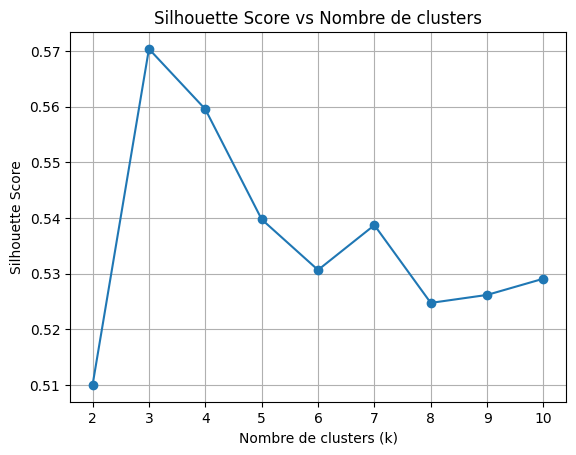

In [46]:
# Liste pour stocker les scores
scores = []

# Boucle sur différents nombres de clusters k (de 2 à 10)
for k in range(2, 11):
    # Entraînement du modèle KMeans sur les données standardisées
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_clustering)

    # Calcul du Silhouette Score (mesure de cohérence des clusters)
    score = silhouette_score(df_clustering, kmeans.labels_)
    scores.append(score)

# Affichage des scores en fonction de k
plt.plot(range(2, 11), scores, marker='o')
plt.title("Silhouette Score vs Nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

le k qui donne le Silhouette Score le plus élevé est souvent le plus pertinent.
Dans notre cas, k=3 donne le meilleur résultat mais on peut aller jusqu'à 10 clusters selon nos résultats mais on se contente de garder k=5

### **Entrainement du modele**

In [47]:
# Étape 5 : Application de KMeans avec 5 clusters
# On suppose que le nombre optimal de clusters pour notre situation est 5, après analyse du Silhouette Score
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df_clustering)  # On utilise les données standardisées

# Étape 6 : Ajout des résultats du clustering au DataFrame original
# Cela permet d’associer chaque match à un groupe (ou segment) identifié par le clustering
df_team['cluster'] = kmeans.labels_


## *Représentation visuelle de la solution*

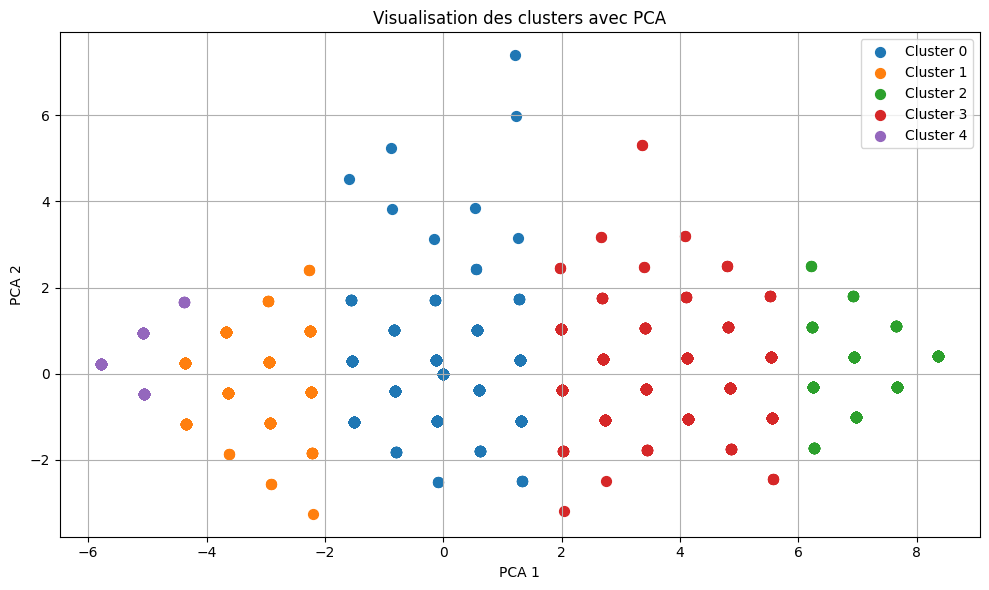

In [48]:
from sklearn.decomposition import PCA

# Réduction de dimension à 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_clustering)

# Création d'un DataFrame pour la visualisation
df_visu = pd.DataFrame()
df_visu['PCA1'] = X_pca[:, 0]
df_visu['PCA2'] = X_pca[:, 1]
df_visu['cluster'] = kmeans.labels_

# Affichage des clusters
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_visu['cluster'].unique()):
    cluster_points = df_visu[df_visu['cluster'] == cluster_id]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster_id}', s=50)

plt.title('Visualisation des clusters avec PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## *Calcul du score de silouhette*

In [49]:
score = silhouette_score(df_clustering, kmeans.labels_)
print(f"le score de silouhette est : {score: .3f}")


le score de silouhette est :  0.540


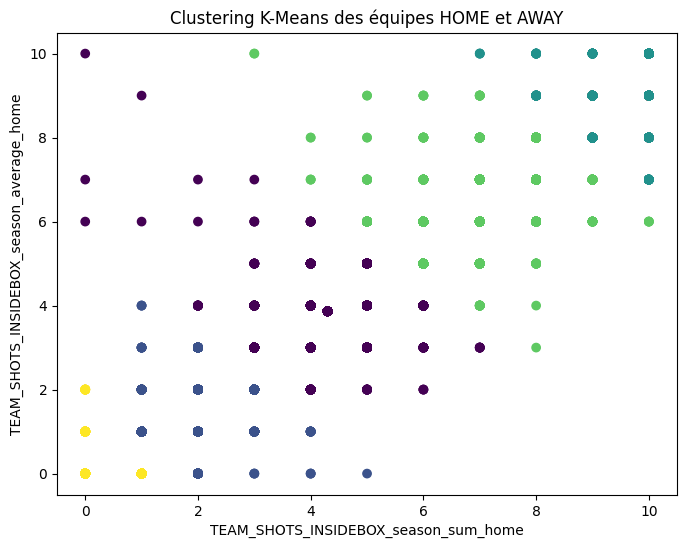

In [50]:
#les clusters avec les deux premières colonnes
plt.figure(figsize=(8, 6))
plt.scatter(df_clustering.iloc[:, 0], df_clustering.iloc[:, 1], c=kmeans.labels_)
plt.title("Clustering K-Means des équipes HOME et AWAY")
plt.xlabel(col_clustering[0])
plt.ylabel(col_clustering[1])
plt.show()

Interprétation du clustering (visuelle)

Le graphique montre 5 couleurs différentes → 5 clusters d'équipes selon leur activité offensive à domicile :

     Cluster jaune :

        Équipes avec peu de tirs dans la surface, et une moyenne très basse.

        Comportement : équipes très défensives ou peu performantes offensivement à domicile.

     Cluster bleu :

        Tirs totaux moyens ou faibles, moyenne aussi faible.

        Comportement : équipes inefficaces à domicile.

     Cluster violet :

        Moyenne et somme des tirs faibles à modérées.

        Comportement : équipes moyennes ou irrégulières, peu de constance dans les performances.

     Cluster vert :

        Moyenne modérée à élevée, somme de tirs élevée.

        Comportement : équipes offensives et régulières à domicile.

     Cluster bleu-vert :

        Très hauts volumes et moyennes de tirs.

        Comportement : équipes très offensives, souvent dominantes à domicile.

